**1. Import necessary libraries**

In [1]:
!pip install implicit
# !pip uninstall numpy -y
# !pip install "numpy<2.0"
# import os
# os.kill(os.getpid(), 9)

In [2]:
# Cell 1:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import avg
import pandas as pd
import scipy.sparse as sparse
import implicit
import numpy as np
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


**2. Create or get Spark session**

In [3]:
spark = SparkSession.builder \
    .appName("ALS_by_Datasize")\
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "50") \
    .getOrCreate()

**3. Load and process data**

In [4]:
rating_df = spark.read.csv('/content/users-score-2023.csv', header=True, inferSchema=True)

In [5]:
rating_df = rating_df.select('user_id', 'anime_id', 'rating')

In [6]:
from pyspark.sql.functions import isnan, col


count_nan_df = rating_df.na.drop().filter(~isnan(col('rating'))).count()

print(f"Total entries: {rating_df.count()}")
print(f"Eligible entries: {count_nan_df}")
print(f"Ratio of eligible entries: {count_nan_df/rating_df.count()*100}%")

Total entries: 14211272
Eligible entries: 14211272
Ratio of eligible entries: 100.0%


In [7]:
from pyspark.sql.functions import avg
rating_df = rating_df.groupBy("user_id", "anime_id").agg(avg("rating").alias("rating"))
rating_df.persist()

DataFrame[user_id: int, anime_id: int, rating: double]

In [8]:
rating_df.show(5)
print(f"Total Ratings: {rating_df.count():,}")

+-------+--------+------+
|user_id|anime_id|rating|
+-------+--------+------+
|      1|     306|   8.0|
|      1|     877|   8.0|
|      1|     198|   9.0|
|      4|    9736|   6.0|
|      4|   21437|   7.0|
+-------+--------+------+
only showing top 5 rows

Total Ratings: 14,211,272


In [9]:
# Sample as % of data
small_fraction = 0.25
medium_fraction = 0.5
large_fraction = 0.75
small_rating_sampled_df = rating_df.sample(fraction=small_fraction, seed=42)
medium_rating_sampled_df = rating_df.sample(fraction=medium_fraction, seed=42)
large_rating_sampled_df = rating_df.sample(fraction=large_fraction, seed=42)
rating_sampled_df = rating_df

**4. Split train/test**

In [10]:
small_train_df, small_test_df = small_rating_sampled_df.randomSplit([0.75, 0.25], seed=42)
# Loại bỏ các dòng có giá trị NaN hoặc null trong cột 'rating'
small_train_df = small_train_df.na.drop(subset=["rating"])
small_test_df = small_test_df.na.drop(subset=["rating"])

medium_train_df, medium_test_df = medium_rating_sampled_df.randomSplit([0.75, 0.25], seed=42)
# Loại bỏ các dòng có giá trị NaN hoặc null trong cột 'rating'
medium_train_df = medium_train_df.na.drop(subset=["rating"])
medium_test_df = medium_test_df.na.drop(subset=["rating"])

large_train_df, large_test_df = large_rating_sampled_df.randomSplit([0.75, 0.25], seed=42)
# Loại bỏ các dòng có giá trị NaN hoặc null trong cột 'rating'
large_train_df = large_train_df.na.drop(subset=["rating"])
large_test_df = large_test_df.na.drop(subset=["rating"])

train_df, test_df = rating_sampled_df.randomSplit([0.75, 0.25], seed=42)
# Loại bỏ các dòng có giá trị NaN hoặc null trong cột 'rating'
train_df = train_df.na.drop(subset=["rating"])
test_df = test_df.na.drop(subset=["rating"])

# Kiểm tra lại số dòng sau khi làm sạch
print(f"Cleaned train_df count: {train_df.count()}")
print(f"Cleaned test_df count: {test_df.count()}")

Cleaned train_df count: 10656345
Cleaned test_df count: 3553191


**5. Training the ALS model**

In [11]:
als = ALS(
    userCol="user_id",
    itemCol="anime_id",
    ratingCol="rating",
    nonnegative=True,
    implicitPrefs=False,
    coldStartStrategy="drop",
    maxIter=10,
    rank=50,
    regParam=0.1
)

In [12]:
# Sample 25% of the data
small_als_model = als.fit(small_train_df)
small_test_predictions = small_als_model.transform(small_test_df)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
small_test_rmse_als = evaluator.evaluate(small_test_predictions)

# Sample 5o% of the data
medium_als_model = als.fit(medium_train_df)
medium_test_predictions = medium_als_model.transform(medium_test_df)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
medium_test_rmse_als = evaluator.evaluate(medium_test_predictions)

# Sample 75% of the data
large_als_model = als.fit(large_train_df)
large_test_predictions = large_als_model.transform(large_test_df)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
large_test_rmse_als = evaluator.evaluate(large_test_predictions)

# Sample 100% of the data
als_model = als.fit(train_df)
test_predictions = als_model.transform(test_df)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
test_rmse_als = evaluator.evaluate(test_predictions)


**6. RMSE based on data set size**

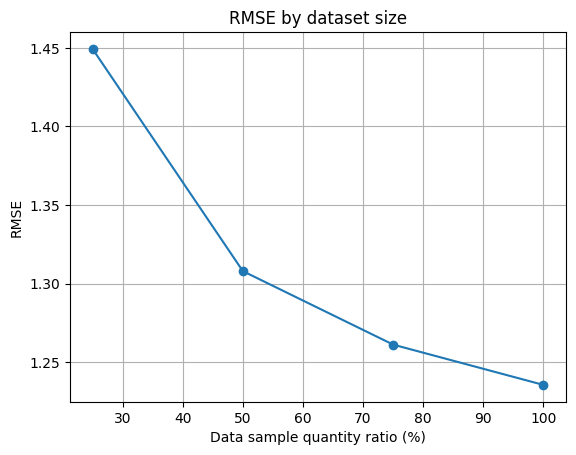

In [14]:
import matplotlib.pyplot as plt

sample_percentages = [25, 50, 75, 100]
rmse_values = [small_test_rmse_als, medium_test_rmse_als,large_test_rmse_als, test_rmse_als]

plt.plot(sample_percentages, rmse_values, marker='o')
plt.xlabel('Data sample quantity ratio (%)')
plt.ylabel('RMSE')
plt.title('RMSE by dataset size')
plt.grid(True)
plt.show()